# photoeccentric effect

paper: https://arxiv.org/pdf/1203.5537.pdf

1. Calculate rho_circ (eq. 7)
2. Calculate rho_star (eq. 6) (already have from spectroscopy + Gaia)
3. Compare them (what is g? g = ratio of rho_star to rho_circ)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import csv
import metallicity as mt
import scipy.constants as c

import PyAstronomy.pyasl as pya

plt.rcParams['figure.figsize'] = [10, 5]

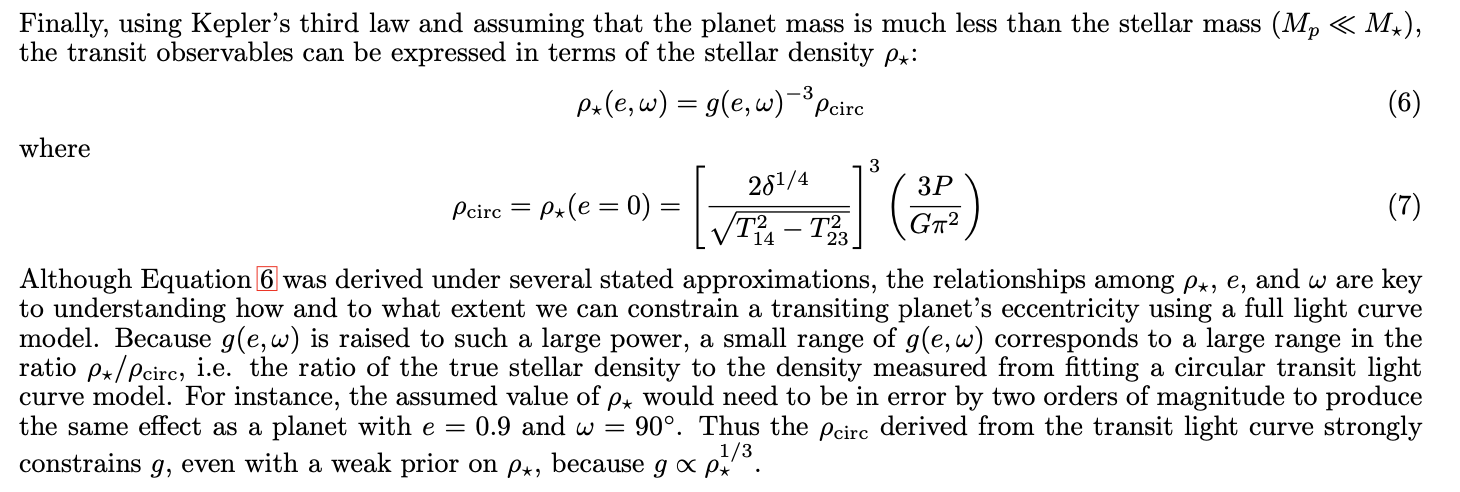

#### Start with KIC 10386984.

In [2]:
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')
rho_star = np.median(rho_lum['10386984'].dropna());

In [3]:
rho_f = rho_lum['10386984'].dropna();

### NASA Exoplanet archive: https://exoplanetarchive.ipac.caltech.edu/applications/Inventory/search.html

#### Columns explained: https://exoplanetarchive.ipac.caltech.edu/docs/API_exoplanet_columns.html

https://arxiv.org/pdf/1807.04886.pdf
Equation 9

https://pyastronomy.readthedocs.io/en/latest/pyaslDoc/aslDoc/transitDuration.html

In [4]:
#Values are from Exoplanet Archive for KIC 10386984 (1 confirmed transiting planet)

p = 1.287 #days
#d = 0.0831 #transit depth
T14 = 1.4942 #hours (1st to 4th contact - full duration (I think?))
ratio = 0.025492 #planet radius/star radius
b = 0.003 #used "cumulative" delivery
a = .0188


rprs = 0.024255
rs = 0.525 #solar radii
i = 89.98

rp = 1.39 #earth radii

p_hours = p*24 #period in hours

In [5]:
ing_eg = 2*pya.ingressDuration(a, rp, rs, i, p)
T23 = T14-ing_eg

#### At some point, write own function to do this without pyastronomy

In [6]:
def planet_params(p, rp_earth, rs, T14, a, i):
    "returns period (seconds), rprs, T14 (seconds), T23 (seconds)"

    ing_eg = 2*pya.ingressDuration(a, rp_earth*11.2, rs, i, p)#rp needs to in jovian radii???
    T23 = T14-ing_eg
    
    rp = rp_earth*0.0091577
    rprs = rp/rs
    

    
    return p*86400, rprs, T14*3600, T23*3600

In [7]:
p, rprs, T14, T23 = planet_params(p, rp, rs, T14, a, i)

In [8]:
def rho_circ(RpRs, T14, T23, P):
    delta = RpRs**2
    num1 = 2*delta**(1/4)
    den1 = np.sqrt(T14**2- T23**2)
    term1 = (num1/den1)**3
    
    num2 = 3*P
    den2 = c.G*c.pi**2
    term2 = num2/den2
    
    rho_circ = term1*term2
    
    return rho_circ


def get_g(rho_circ, rho_star):
    return np.cbrt(rho_c/rho_star)


def get_e(g):
    e = np.sqrt(-(1/g)**2+1)
    return e

In [9]:
T23

4959.926210530448

In [10]:
rho_c = rho_circ(rprs, T14, T23, p*24)

In [11]:
g = get_g(rho_c, rho_star)

In [12]:
g

1.910453076981281

In [13]:
get_e(g)

0.8520649671910994

In [14]:
def asymmetric_gaussian(mean, sigma_minus, sigma_plus, nvals):
    """Generates an asymmetric Gaussian distribution based on a mean and 2 different sigmas (one (-) and one (+))
    Made by generating 2 symmetric Gaussians with different sigmas and sticking them together at the mean.
    The integral of the resulting Gaussian is 1.

    Parameters
    ----------
    mean: float
        Mean of distribution
    sigma_minus: float
        Negative sigma of distribtion
    sigma_plus: float
        Positive sigma of distribtion
    nvals: int
        Number of values

    Results
    -------
    dist: np.ndarray
        Asymmetric Gaussian distribution, length nvals
    """

    left = np.random.normal(mean, abs(sigma_minus), nvals+200)
    right = np.random.normal(mean, abs(sigma_plus), nvals+200)
    dist_left = left[left<mean]
    dist_right = right[right>=mean]
    dist = np.concatenate((dist_right, dist_left), axis=None)

    np.random.shuffle(dist)

    while len(dist) > nvals:
        dist = np.delete(dist, [np.random.randint(0, len(dist)-1)])
    else:
        return dist

In [15]:
p_dist = np.random.normal(p, 1.2e-06, len(rho_f))

In [16]:
rprs_dist = asymmetric_gaussian(0.024255, 0.000778, -0.000257, len(rho_f))

In [17]:
T14_dist = np.random.normal(T14/24., 0.0279/24., len(rho_f))

In [18]:
T23_dist = np.random.normal(T23/24., 0.0378/24., len(rho_f))

In [19]:
es = []
gs = []

for i in range(len(rho_f)):
    rho_c = rho_circ(rprs_dist[i], T14_dist[i], T23_dist[i], p_dist[i])
    g = get_g(rho_c, rho_f[i])
    gs.append(g)
    es.append(get_e(g))

Text(0.5, 0, '$e$')

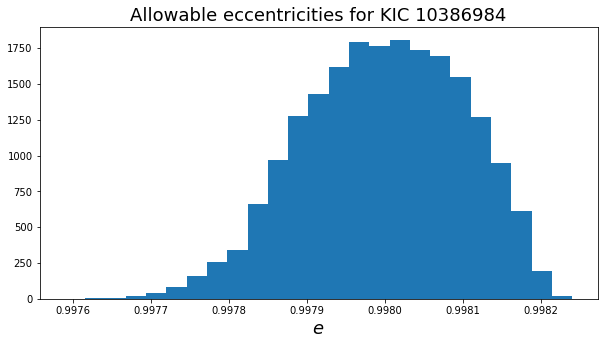

In [20]:
plt.ticklabel_format(style='plain', useOffset=False)
plt.hist(es, bins=25);
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.title('Allowable eccentricities for KIC 10386984', fontsize=18)
plt.xlabel('$e$', fontsize=18)

Text(0.5, 0, '$g$')

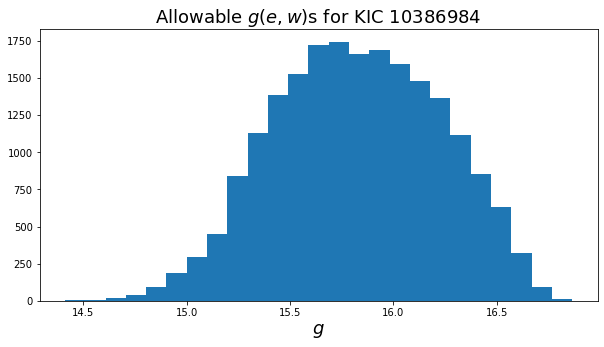

In [21]:
plt.ticklabel_format(style='plain', useOffset=False)
plt.hist(gs, bins=25);
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Allowable $g(e,w)$s for KIC 10386984', fontsize=18)
plt.xlabel('$g$', fontsize=18)

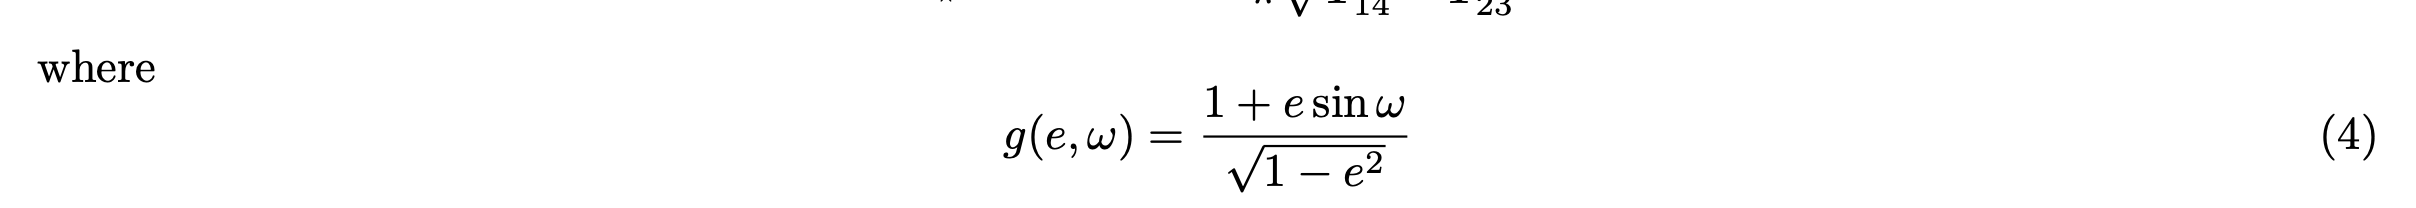

Assuming omega = 0 for now.

Now need to solve for e with w.

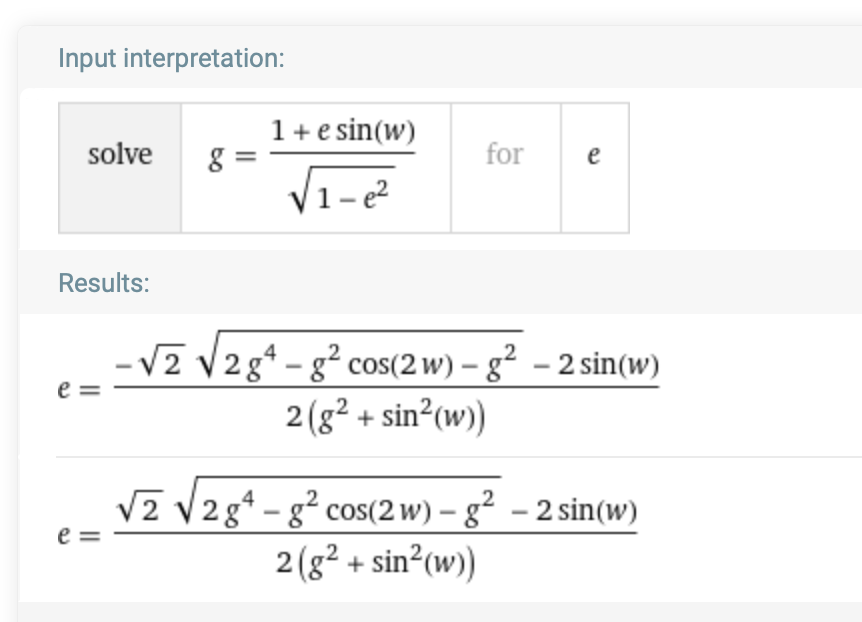

In [22]:
def get_e(g, w):
    e = (np.sqrt(2)*(np.sqrt(2*g**4 - g**2*np.cos(2*w) - g**2 - 2*np.sin(w))))/(2*(g**2 + np.sin(w)**2))
    return e

In [23]:
get_e(7, 0)

0.9897433186107871

In [24]:
ws = np.linspace(-90, 90, len(gs))

In [25]:
es = []
gs = []

for i in range(len(rho_f)):
    rho_c = rho_circ(rprs_dist[i], T14_dist[i], T23_dist[i], p_dist[i])
    g = get_g(rho_c, rho_f[i])
    gs.append(g)
    es.append(get_e(g, 90))

Text(0.5, 0, '$e$')

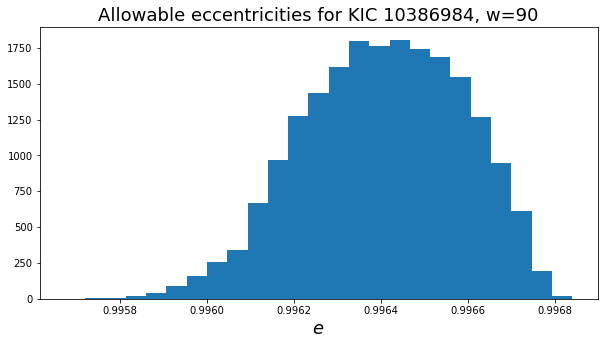

In [26]:
plt.ticklabel_format(style='plain', useOffset=False)
plt.hist(es, bins=25);
plt.gcf().axes[0].xaxis.get_major_formatter().set_scientific(False)
plt.title('Allowable eccentricities for KIC 10386984, w=90', fontsize=18)
plt.xlabel('$e$', fontsize=18)

Text(0.5, 0, '$g$')

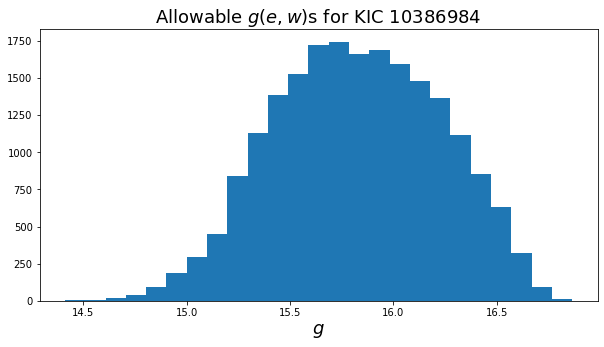

In [27]:
plt.ticklabel_format(style='plain', useOffset=False)
plt.hist(gs, bins=25);
plt.gcf().axes[0].yaxis.get_major_formatter().set_scientific(False)
plt.title('Allowable $g(e,w)$s for KIC 10386984', fontsize=18)
plt.xlabel('$g$', fontsize=18)

Read in exoplanet data from csv

In [28]:
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')


In [29]:
planets

,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,0,...,0.200,0.160,0.200,0.170,0.080,0.130,0.310,0.170,0.320,0.160
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,Done,8/16/18,CANDIDATE,0.969,0,0,...,0.000,0.480,0.390,0.360,0.490,0.340,0.120,0.730,0.500,0.450
2,10811496,K00753.01,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.000,0,0,...,-0.034,0.070,0.042,0.072,0.002,0.071,-0.027,0.074,0.027,0.074
3,10848459,K00754.01,NaN,FALSE POSITIVE,Done,8/16/18,FALSE POSITIVE,0.000,0,1,...,0.147,0.078,0.289,0.079,-0.257,0.072,0.099,0.077,0.276,0.076
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,0,...,-0.090,0.180,0.100,0.140,0.070,0.180,0.020,0.160,0.070,0.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9559,10090151,K07985.01,NaN,FALSE POSITIVE,Done,8/16/18,FALSE POSITIVE,0.000,0,1,...,-1.757,0.068,2.763,0.074,2.344,0.072,-1.756,0.068,2.929,0.072
9560,10128825,K07986.01,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.497,0,0,...,-0.250,0.490,0.780,0.460,0.500,0.400,-0.180,0.470,0.530,0.470
9561,10147276,K07987.01,NaN,FALSE POSITIVE,Done,8/16/18,FALSE POSITIVE,0.021,0,0,...,-3.650,0.260,5.000,0.220,3.380,0.160,-3.890,0.260,5.160,0.220
9562,10155286,K07988.01,NaN,CANDIDATE,Done,8/16/18,CANDIDATE,0.092,0,0,...,1.320,0.670,1.690,0.530,1.450,0.110,1.370,0.660,2.000,0.460


In [30]:
rho_lum.columns

Index(['10386984', '8346392', '7021681', '10990886', '6435936', '9787239',
       '3426367', '10166274', '11192235', '8351704', '11187837', '5601258',
       '9150827', '10395543', '2556650', '10525027', '11337141', '10905746',
       '11129738', '6666233', '5384713', '8561063', '5868793', '8367644',
       '5809954', '8890150', '11923270', '11348997', '9390653', '8631751',
       '10670119', '8235924', '8229458', '8167996', '10388286', '4061149',
       '10489206', '7907423', '9757613', '9427402', '2973386', '11852982',
       '4172805', '6773862', '5364071', '9573685', '10525049', '11853130',
       '9761199', '5531953', '3642335', '10591855', '9388479', '4139816',
       '10122538', '8733898'],
      dtype='object')

In [31]:
koiplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]

In [60]:
for i in range(len(koiplanets)):
    kepid = koiplanets['kepid'].iloc[i]
    #print(kepid)
    #print(koiplanets.loc[koiplanets['kepid'] == kepid].koi_period)
    perKOI = float(koiplanets.loc[koiplanets['kepid'] == kepid].koi_period)
    #print(perKOI)

TypeError: cannot convert the series to <class 'float'>

In [32]:
perKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_period)
per_uerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_period_err1)
per_lerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_period_err2)

rp_earthKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_prad)
rp_earth_uerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_prad_err1)
rp_earth_lerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_prad_err2)

rsKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_srad)

T14KOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_duration)
T14_uerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_duration_err1)
T14_lerrKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_duration_err2)

aKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_sma)

iKOI = float(koiplanets.loc[koiplanets['kepid'] == 10386984].koi_incl)

In [33]:
pKOI, rprsKOI, T14KOI, T23KOI = planet_params(perKOI, rp_earthKOI, rsKOI, T14KOI, aKOI, iKOI)

In [34]:
p_dist = asymmetric_gaussian(pKOI, per_uerrKOI, per_lerrKOI, len(rho_lum['10386984']))

rprs_dist = asymmetric_gaussian(rp_earthKOI, rp_earth_uerrKOI, rp_earth_lerrKOI, len(rho_lum['10386984']))

T14_dist = asymmetric_gaussian(T14KOI, T14_uerrKOI, T14_lerrKOI, len(rho_lum['10386984']))

T23_dist = np.random.normal(T23/24., 0.0378/24., len(rho_f))